# A case-control study of autoimmune AEFIs following COVID-19 vaccination reported to VAERS

_Chris von Csefalvay_

_04 July 2021_

## Analysis plan

1. Import VAERS data from 1995 onwards, to give a sufficient number of records.
2. We then bracket age groups.
3. We use `pymatch` to create a matched set of controls by:
    * age band
    * gender
4. We filter for autoimmune aetiologies.
5. Finally, we calculate the reporting odds ratios of all symptoms.

In [41]:
import scipy
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymatch
from pymatch.Matcher import Matcher
import sys, re, platform, glob
from tqdm.autonotebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Fixed seed for reproducibility
np.random.seed(4072021)

print(f"Python version: {sys.version}")
print(f"OS version: {platform.platform()}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"statsmodels version: {statsmodels.__version__}")

Python version: 3.7.5 (v3.7.5:5c02a39a0b, Oct 14 2019, 18:49:57) 
[Clang 6.0 (clang-600.0.57)]
OS version: Darwin-20.2.0-x86_64-i386-64bit
pandas version: 1.3.0
numpy version: 1.21.0
scipy version: 1.7.0
statsmodels version: 0.12.2


## Analysis

### Loading VAERS data

Note: for legal reasons, we cannot reproduce the raw VAERS data in Github. However, you can download the VAERS data set
from [HHS](https://vaers.hhs.gov).

In [2]:
%%time

path = "../data/" # use your path
vaccine_files = glob.glob(path + "*VAERSVAX.csv")

vax_frames = []

for filename in tqdm(vaccine_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    vax_frames.append(df)

vax = pd.concat(vax_frames, axis=0, ignore_index=True)[["VAERS_ID", "VAX_TYPE"]]
vax["VAX_TYPE"] = vax["VAX_TYPE"] == "COVID19"
vax.columns = ["VAERS_ID", "IS_COVID_VACCINE"]

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 1.78 s, sys: 367 ms, total: 2.15 s
Wall time: 2.57 s


In [3]:
%%time

recipient_files = glob.glob(path + "*VAERSDATA.csv")

recipient_frames = []

for filename in tqdm(recipient_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    recipient_frames.append(df)

recipients = pd.concat(recipient_frames, axis=0, ignore_index=True)[["VAERS_ID", "SEX", "CAGE_YR"]]

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 10.3 s, sys: 2.03 s, total: 12.3 s
Wall time: 12.8 s


We age-band recipients by specifying the left margin of each age band.

In [4]:
%%time

age_bands = {0: "<18",
             18: "18-25",
             26: "26-40",
             41: "41-55",
             56: "56-70",
             71: ">70",
             int(recipients.CAGE_YR.max()): "max"}

recipients["AGE"] = pd.cut(recipients.CAGE_YR, bins=list(age_bands.keys()), labels=list(age_bands.values())[:-1])
recipients = recipients.drop("CAGE_YR", axis=1).dropna()

CPU times: user 134 ms, sys: 27.3 ms, total: 161 ms
Wall time: 159 ms


In [5]:
%%time

symptoms_files = glob.glob(path + "*VAERSSYMPTOMS.csv")

symptoms_frames = []

for filename in tqdm(symptoms_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    symptoms_frames.append(df)


symptoms = pd.melt(pd.concat(symptoms_frames, axis=0, ignore_index=True)[["VAERS_ID", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]],
               id_vars="VAERS_ID",
               value_vars=(f"SYMPTOM{i}" for i in range(1, 6))).drop("variable", axis=1)

symptoms.columns = ("VAERS_ID", "SYMPTOM")

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 1.86 s, sys: 463 ms, total: 2.33 s
Wall time: 2.35 s


In [6]:
%%time

vaccination_data = vax.merge(recipients, how="inner", on="VAERS_ID")

CPU times: user 206 ms, sys: 110 ms, total: 316 ms
Wall time: 316 ms


### Classifying cases vs controls

In [7]:
autoimmune_conditions = (
    "Alveolar proteinosis",
    "Ankylosing spondylitis",
    "Anti-glomerular basement membrane disease",
    "Antisynthetase syndrome",
    "Autoimmune colitis",
    "Autoimmune disorder",
    "Autoimmune enteropathy",
    "Autoimmune eye disorder",
    "Autoimmune hyperlipidaemia",
    "Autoimmune inner ear disease",
    "Autoimmune lung disease",
    "Autoimmune lymphoproliferative syndrome",
    "Autoimmune myocarditis",
    "Autoimmune nephritis",
    "Autoimmune pericarditis",
    "Autoimmune retinopathy",
    "Autoimmune uveitis",
    "Axial spondyloarthritis",
    "Birdshot chorioretinopathy",
    "Chronic autoimmune glomerulonephritis",
    "Chronic gastritis",
    "Chronic recurrent multifocal osteomyelitis",
    "Coeliac disease",
    "Collagen disorder",
    "Collagen-vascular disease",
    "Cryofibrinogenaemia",
    "Cryoglobulinaemia",
    "Dermatomyositis",
    "Dressler's syndrome",
    "Glomerulonephritis rapidly progressive",
    "Goodpasture's syndrome",
    "Immunoglobulin G4 related disease",
    "IPEX syndrome",
    "Juvenile spondyloarthritis",
    "Keratoderma blenorrhagica",
    "Mixed connective tissue disease",
    "Myocarditis post infection",
    "Ocular pemphigoid",
    "Ocular pemphigoid",
    "Overlap syndrome",
    "Polychondritis",
    "Postpericardiotomy syndrome",
    "Pulmonary renal syndrome",
    "Satoyoshi syndrome",
    "Sjogren's syndrome",
    "Sympathetic ophthalmia",
    "Testicular autoimmunity",
    "Undifferentiated connective tissue disease",
    "Antiphospholipid syndrome",
    "Autoimmune anaemia",
    "Autoimmune aplastic anaemia",
    "Autoimmune haemolytic anaemia",
    "Autoimmune heparin-induced thrombocytopenia",
    "Autoimmune neutropenia",
    "Autoimmune pancytopenia",
    "Cold type haemolytic anaemia",
    "Coombs positive haemolytic anaemia",
    "Evans syndrome",
    "Pernicious anaemia",
    "Warm type haemolytic anaemia",
    "Addison's disease",
    "Atrophic thyroiditis",
    "Autoimmune endocrine disorder",
    "Autoimmune hypothyroidism",
    "Autoimmune pancreatitis",
    "Autoimmune thyroid disorder",
    "Autoimmune thyroiditis",
    "Basedow's disease",
    "Diabetic mastopathy",
    "Endocrine ophthalmopathy",
    "Hashimoto's encephalopathy",
    "Hashitoxicosis",
    "Insulin autoimmune syndrome",
    "Ketosis-prone diabetes mellitus",
    "Latent autoimmune diabetes in adults",
    "Lymphocytic hypophysitis",
    "Marine Lenhart syndrome",
    "Polyglandular autoimmune syndrome type I",
    "Polyglandular autoimmune syndrome type II",
    "Polyglandular autoimmune syndrome type III",
    "Silent thyroiditis",
    "Type 1 diabetes mellitus",
    "Alloimmune hepatitis",
    "Autoimmune cholangitis",
    "Autoimmune hepatitis",
    "Cholangitis sclerosing",
    "Primary biliary cholangitis",
    "Acute cutaneous lupus erythematosus",
    "Butterfly rash",
    "Central nervous system lupus",
    "Chronic cutaneous lupus erythematosus",
    "Cutaneous lupus erythematosus",
    "Lupoid hepatic cirrhosis",
    "Lupus cystitis",
    "Lupus encephalitis",
    "Lupus endocarditis",
    "Lupus enteritis",
    "Lupus hepatitis",
    "Lupus myocarditis",
    "Lupus myositis",
    "Lupus nephritis",
    "Lupus pancreatitis",
    "Lupus pleurisy",
    "Lupus pneumonitis",
    "Lupus vasculitis",
    "Lupus-like syndrome",
    "Neonatal lupus erythematosus",
    "Neuropsychiatric lupus",
    "Pericarditis lupus",
    "Peritonitis lupus",
    "Shrinking lung syndrome",
    "SLE arthritis",
    "Subacute cutaneous lupus erythematosus",
    "Systemic lupus erythematosus",
    "Systemic lupus erythematosus rash",
    "Autoimmune myositis",
    "Congenital myasthenic syndrome",
    "Inclusion body myositis",
    "Juvenile polymyositis",
    "Morvan syndrome",
    "Myasthenia gravis",
    "Myasthenia gravis crisis",
    "Myasthenia gravis neonatal",
    "Myasthenic syndrome",
    "Neuromyotonia",
    "Ocular myasthenia",
    "Polymyalgia rheumatica",
    "Polymyositis",
    "Acute disseminated encephalomyelitis",
    "Acute haemorrhagic leukoencephalitis",
    "Acute motor axonal neuropathy",
    "Acute motor-sensory axonal neuropathy",
    "Anti-myelin-associated glycoprotein associated polyneuropathy",
    "Autoimmune demyelinating disease",
    "Autoimmune encephalopathy",
    "Autoimmune neuropathy",
    "Axonal and demyelinating polyneuropathy",
    "Bickerstaff's encephalitis",
    "Chronic inflammatory demyelinating polyradiculoneuropathy",
    "Chronic lymphocytic inflammation with pontine perivascular enhancement responsive to steroid",
    "Concentric sclerosis",
    "Demyelinating polyneuropathy",
    "Encephalitis allergic",
    "Encephalitis autoimmune",
    "Faciobrachial dystonic seizure",
    "Guillain-Barre syndrome",
    "Leukoencephalomyelitis",
    "Limbic encephalitis",
    "Multiple sclerosis",
    "Myelitis transverse",
    "Neuralgic amyotrophy",
    "Neuromyelitis optica pseudo relapse",
    "Neuromyelitis optica spectrum disorder",
    "Paediatric autoimmune neuropsychiatric disorders associated with streptococcal infection",
    "POEMS syndrome",
    "Radiologically isolated syndrome",
    "Rasmussen encephalitis",
    "Secondary cerebellar degeneration",
    "Stiff leg syndrome",
    "Stiff person syndrome",
    "Subacute inflammatory demyelinating polyneuropathy",
    "Susac's syndrome",
    "Toxic oil syndrome",
    "Autoimmune arthritis",
    "Caplan's syndrome",
    "Cogan's syndrome",
    "Felty's syndrome",
    "Juvenile idiopathic arthritis",
    "Laryngeal rheumatoid arthritis",
    "Palindromic rheumatism",
    "Rheumatoid arthritis",
    "Rheumatoid lung",
    "Rheumatoid neutrophilic dermatosis",
    "Rheumatoid nodule",
    "Rheumatoid scleritis",
    "Rheumatoid vasculitis",
    "CREST syndrome",
    "Digital pitting scar",
    "Morphoea",
    "Reynold's syndrome",
    "Sclerodactylia",
    "Scleroderma",
    "Scleroderma associated digital ulcer",
    "Scleroderma renal crisis",
    "Scleroderma-like reaction",
    "Systemic scleroderma",
    "Systemic sclerosis pulmonary",
    "Acquired epidermolysis bullosa",
    "Alopecia areata",
    "Autoimmune blistering disease",
    "Autoimmune dermatitis",
    "Benign familial pemphigus",
    "Dermatitis herpetiformis",
    "Eosinophilic fasciitis",
    "Epidermolysis",
    "Granulomatous dermatitis",
    "Herpes gestationis",
    "Interstitial granulomatous dermatitis",
    "Linear IgA disease",
    "Nephrogenic systemic fibrosis",
    "Palisaded neutrophilic granulomatous dermatitis",
    "Paraneoplastic dermatomyositis",
    "Paraneoplastic pemphigus",
    "Pemphigoid",
    "Pemphigus",
    "Pityriasis lichenoides et varioliformis acuta",
    "Progressive facial hemiatrophy",
    "Pyoderma gangrenosum",
    "Vitiligo",
    "Autoinflammation with infantile enterocolitis",
    "Autoinflammatory disease",
    "Blau syndrome",
    "CANDLE syndrome",
    "Chronic infantile neurological cutaneous and articular syndrome",
    "Cryopyrin associated periodic syndrome",
    "Deficiency of the interleukin-1 receptor antagonist",
    "Deficiency of the interleukin-36 receptor antagonist",
    "Familial cold autoinflammatory syndrome",
    "Hyper IgD syndrome",
    "Majeed's syndrome",
    "Mevalonate kinase deficiency",
    "Mevalonic aciduria",
    "Muckle-Wells syndrome",
    "PASH syndrome",
    "PSTPIP1-associated myeloid-related proteinaemia inflammatory syndrome",
    "Pyogenic sterile arthritis pyoderma gangrenosum and acne syndrome",
    "Still's disease",
    "Acquired amegakaryocytic thrombocytopenia",
    "Acquired complement deficiency disease",
    "Acute graft versus host disease",
    "Acute graft versus host disease in intestine",
    "Acute graft versus host disease in liver",
    "Acute graft versus host disease in skin",
    "Acute graft versus host disease oral",
    "Amegakaryocytic thrombocytopenia",
    "Anamnestic reaction",
    "Aplasia pure red cell",
    "Arthritis enteropathic",
    "Arthritis reactive",
    "Bacille Calmette-Guerin scar reactivation",
    "Bronchiolitis obliterans syndrome",
    "C1q nephropathy",
    "C3 glomerulopathy",
    "CEC syndrome",
    "Central nervous system immune reconstitution inflammatory response",
    "Chronic graft versus host disease",
    "Chronic graft versus host disease in eye",
    "Chronic graft versus host disease in intestine",
    "Chronic graft versus host disease in liver",
    "Chronic graft versus host disease in skin",
    "Chronic graft versus host disease oral",
    "Colitis ulcerative",
    "Congenital thrombocytopenia",
    "Crohn's disease",
    "Cystitis interstitial",
    "Cytokine release syndrome",
    "Cytokine storm",
    "Cytophagic histiocytic panniculitis",
    "De novo purine synthesis inhibitors associated acute inflammatory syndrome",
    "Decreased immune responsiveness",
    "Encephalitis post varicella",
    "Engraftment syndrome",
    "Enteropathic spondylitis",
    "Episcleritis",
    "Erythema nodosum",
    "Erythrodermic psoriasis",
    "Febrile infection-related epilepsy syndrome",
    "Fibrillary glomerulonephritis",
    "Giant cell myocarditis",
    "Glomerulonephritis",
    "Graft versus host disease",
    "Graft versus host disease in eye",
    "Graft versus host disease in gastrointestinal tract",
    "Graft versus host disease in liver",
    "Graft versus host disease in lung",
    "Graft versus host disease in skin",
    "Guttate psoriasis",
    "Haemophagocytic lymphohistiocytosis",
    "Heparin-induced thrombocytopenia",
    "Hypergammaglobulinaemia",
    "Hypocomplementaemia",
    "Idiopathic interstitial pneumonia",
    "Idiopathic pulmonary fibrosis",
    "IgA nephropathy",
    "IgM nephropathy",
    "Immune reconstitution inflammatory syndrome",
    "Immune reconstitution inflammatory syndrome associated Kaposi's sarcoma",
    "Immune reconstitution inflammatory syndrome associated tuberculosis",
    "Immune recovery uveitis",
    "Immune system disorder",
    "Immune thrombocytopenia",
    "Immune-mediated adverse reaction",
    "Immune-mediated arthritis",
    "Immune-mediated cholangitis",
    "Immune-mediated cholestasis",
    "Immune-mediated cytopenia",
    "Immune-mediated dermatitis",
    "Immune-mediated encephalitis",
    "Immune-mediated encephalopathy",
    "Immune-mediated endocrinopathy",
    "Immune-mediated enterocolitis",
    "Immune-mediated gastritis",
    "Immune-mediated hepatic disorder",
    "Immune-mediated hepatitis",
    "Immune-mediated hyperthyroidism",
    "Immune-mediated hypothyroidism",
    "Immune-mediated myocarditis",
    "Immune-mediated myositis",
    "Immune-mediated nephritis",
    "Immune-mediated neuropathy",
    "Immune-mediated pancreatitis",
    "Immune-mediated pneumonitis",
    "Immune-mediated renal disorder",
    "Immune-mediated thyroiditis",
    "Immune-mediated uveitis",
    "Immunisation reaction",
    "Infection masked",
    "Infection susceptibility increased",
    "Interstitial lung disease",
    "Iritis",
    "Jarisch-Herxheimer reaction",
    "Juvenile psoriatic arthritis",
    "Kaposi sarcoma inflammatory cytokine syndrome",
    "Keratic precipitates",
    "Lewis-Sumner syndrome",
    "Mast cell activation syndrome",
    "Mastocytic enterocolitis",
    "Mazzotti reaction",
    "Membranous-like glomerulopathy with masked IgG-kappa deposits",
    "Metastatic cutaneous Crohn's disease",
    "Multifocal motor neuropathy",
    "Multiple chemical sensitivity",
    "Multisystem inflammatory syndrome in children",
    "Myofascitis",
    "Nail psoriasis",
    "Neonatal alloimmune thrombocytopenia",
    "Neonatal Crohn's disease",
    "Neuronophagia",
    "Neutrophil extracellular trap formation",
    "Noninfectious myelitis",
    "Obliterative bronchiolitis",
    "Optic neuritis",
    "Optic perineuritis",
    "Palmoplantar pustulosis",
    "Paradoxical psoriasis",
    "Paraneoplastic retinopathy",
    "Pathergy reaction",
    "Pleuroparenchymal fibroelastosis",
    "Polyneuropathy in malignant disease",
    "Postcolectomy panenteritis",
    "Pre-engraftment immune reaction",
    "Proctitis ulcerative",
    "Pseudomononucleosis",
    "Psoriasis",
    "Psoriatic arthropathy",
    "Pulmonary sensitisation",
    "Pustular psoriasis",
    "Pustulotic arthro-osteitis",
    "Pyostomatitis vegetans",
    "Reactive angioendotheliomatosis",
    "Reactive capillary endothelial proliferation",
    "Rebound psoriasis",
    "Retroperitoneal fibrosis",
    "Rheumatic brain disease",
    "Rheumatic disorder",
    "Rheumatic fever",
    "Sacroiliitis",
    "SAPHO syndrome",
    "Scleritis",
    "Sensitisation",
    "Sepsis syndrome",
    "Spontaneous heparin-induced thrombocytopenia syndrome",
    "Subacute sclerosing panencephalitis",
    "Systemic immune activation",
    "Systemic mastocytosis",
    "Tachyphylaxis",
    "Thymus disorder",
    "Thymus enlargement",
    "Transfusion associated graft versus host disease",
    "Transfusion microchimerism",
    "Tubulointerstitial nephritis and uveitis syndrome",
    "Ulcerative keratitis",
    "Uveitis",
    "Vogt-Koyanagi-Harada disease",
    "Acute haemorrhagic oedema of infancy",
    "Administration site vasculitis",
    "Angiopathic neuropathy",
    "Anti-neutrophil cytoplasmic antibody positive vasculitis",
    "Application site vasculitis",
    "Behcet's syndrome",
    "Catheter site vasculitis",
    "Central nervous system vasculitis",
    "Cutaneous vasculitis",
    "Diffuse vasculitis",
    "Eosinophilic granulomatosis with polyangiitis",
    "Giant cell arteritis",
    "Granulomatosis with polyangiitis",
    "Haemorrhagic vasculitis",
    "Henoch-Schonlein purpura",
    "Henoch-Schonlein purpura nephritis",
    "Hypersensitivity vasculitis",
    "Infected vasculitis",
    "Infusion site vasculitis",
    "Injection site vasculitis",
    "Kawasaki's disease",
    "MAGIC syndrome",
    "Medical device site vasculitis",
    "Microscopic polyangiitis",
    "Nodular vasculitis",
    "Ocular vasculitis",
    "Palpable purpura",
    "Polyarteritis nodosa",
    "Pseudovasculitis",
    "Pulmonary vasculitis",
    "Renal vasculitis",
    "Retinal vasculitis",
    "Segmented hyalinising vasculitis",
    "Stoma site vasculitis",
    "Takayasu's arteritis",
    "Thromboangiitis obliterans",
    "Vaccination site vasculitis",
    "Vasculitic rash",
    "Vasculitic ulcer",
    "Vasculitis",
    "Vasculitis gastrointestinal",
    "Vasculitis necrotising"
)

In [8]:
p_normals = r".*negative$|.*\snormal$|.*(scopy|graphy|gram|metry|opsy)$|.*(count|percentage|level|test|assay|culture|X-ray|imaging|gradient|band(s)?|index|surface area|gas|scale|antibod(y|ies)|urine absent|Carotid pulse|partial pressure|time|P(C)?O2)$|Oxygen saturation$|End-tidal.*"
p_tests = r".*(ase|ose|ine|enzyme|in|ine|ines|ium|ol|ole|ate|lytes|ogen|gases|oids|ide|one|an|copper|iron)$|.*(level therapeutic)$|.*(globulin)\s.{1,2}$|Barium (swallow|enema)"
p_procedures = r".*(plasty|insertion|tomy|ery|puncture|therapy|treatment|tripsy|operation|repair|procedure|bypass|insertion|removal|graft|closure|implant|lavage|support|transplant|match|bridement|application|ablation)$|Incisional drainage$|.* stimulation$|Immunisation$"
p_normal_procedures = r"(Biopsy|pH|.* examination|X-ray|.* pulse|Blood|Electro(.*)gram|.* test(s)?|Echo(.*)gram|.*(scopy)|Cardiac (imaging|monitoring|ventriculogram)|Chromosomal|Carbohydrate antigen|Cell marker|.* examination|Computerised tomogram|Culture|.* evoked potential(s)?|Cytology|Doppler)(?!.*(abnormal|increased|decreased|depression|elevation|present|absent))"
p_managements = r"(Catheter|Device\).*|.* care$|.* user$|Cardiac pacemaker .*"
p_other_irrelevants = r"Blood group.*|Blood don(or|ation)$|Drug (abuse(r)?|dependence|screen).*|Elderly|Non-tobacco user|No adverse event"
p_covid_related = r".*COVID-19(prophylaxis|immunisation|screening)|Asymptomatic COVID-19"

p = re.compile("|".join([p_normals, p_tests, p_procedures, p_normal_procedures, p_other_irrelevants, p_covid_related]))

In [9]:
%%time

symptoms = symptoms[symptoms.SYMPTOM.str.match(p) == False]


CPU times: user 26.6 s, sys: 250 ms, total: 26.9 s
Wall time: 27.4 s


In [10]:
symptoms["IS_AUTOIMMUNE"] = symptoms.SYMPTOM.isin(autoimmune_conditions)

In [11]:
%%time

instances = vax.merge(symptoms[["VAERS_ID", "IS_AUTOIMMUNE"]].groupby("VAERS_ID").agg({"IS_AUTOIMMUNE": np.max}), how="inner", left_on="VAERS_ID", right_index=True).merge(recipients, how="inner").groupby("VAERS_ID").first()

CPU times: user 42.1 s, sys: 624 ms, total: 42.8 s
Wall time: 43.7 s


In [12]:
pd.crosstab(instances.IS_COVID_VACCINE, instances.IS_AUTOIMMUNE)

IS_AUTOIMMUNE,False,True
IS_COVID_VACCINE,,
False,445900,6969
True,342148,2318


In [13]:
cases = instances[instances.IS_AUTOIMMUNE == True]
controls = instances[instances.IS_AUTOIMMUNE == False]

cases["VAERS_ID"] = cases.index
controls["VAERS_ID"] = controls.index

### Match cases and controls

In [14]:
m = Matcher(cases, controls, yvar="IS_AUTOIMMUNE", exclude=["VAERS_ID"])

Formula:
IS_AUTOIMMUNE ~ IS_COVID_VACCINE+SEX+AGE
n majority: 788048
n minority: 9287


In [15]:
%%time

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 59.3%
CPU times: user 49.5 s, sys: 9.36 s, total: 58.8 s
Wall time: 21.4 s


In [16]:
%%time

m.predict_scores()

CPU times: user 12.1 s, sys: 3.31 s, total: 15.4 s
Wall time: 4.48 s


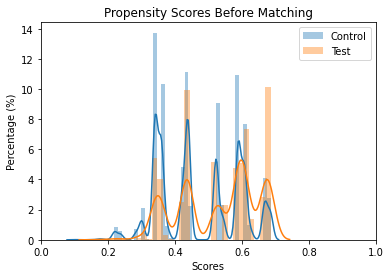

In [50]:
m.plot_scores()
plt.savefig("../writeup/propensity_scores.pdf")

In [18]:
%%time

m.match(method="random", nmatches=3)

CPU times: user 1min 12s, sys: 2.24 s, total: 1min 14s
Wall time: 1min 19s


In [19]:
%%time

m.record_frequency()

CPU times: user 16.4 ms, sys: 9.78 ms, total: 26.2 ms
Wall time: 25.6 ms


,freq,n_records
0,1,33318
1,2,496
2,3,9


In [20]:
%%time

m.assign_weight_vector()

CPU times: user 22.9 ms, sys: 6.07 ms, total: 29 ms
Wall time: 27.7 ms


In [21]:
m.matched_data.head()

,record_id,weight,IS_COVID_VACCINE,IS_AUTOIMMUNE,SEX,AGE,VAERS_ID,scores,match_id
0,0,1.0,False,1,F,56-70,69995,0.590839,0
1,1,1.0,False,1,F,41-55,69996,0.608440,1
2,2,1.0,False,1,M,56-70,69997,0.669988,2
3,3,1.0,False,1,M,41-55,70010,0.685987,3
4,4,1.0,False,1,M,<18,70021,0.522968,4


In [22]:
matched_up_symptoms = m.matched_data.merge(symptoms.dropna(), how="inner").drop_duplicates()

In [23]:
xt_by_symptom = pd.DataFrame(pd.crosstab(index=matched_up_symptoms.IS_COVID_VACCINE, columns=matched_up_symptoms.SYMPTOM))



In [24]:
odds_ratios_by_symptom = pd.DataFrame(columns=xt_by_symptom.columns,
                                      index=xt_by_symptom.index)

symptom_sums = xt_by_symptom.sum(axis=0)
vax_sums = xt_by_symptom.sum(axis=1)[True]
xt_by_symptom_total = xt_by_symptom.sum().sum()

symptom_iterator = tqdm(xt_by_symptom.columns)

res = pd.DataFrame(index = xt_by_symptom.columns, columns = ("ROR", "SE", "95CI_upper", "95CI_lower"))

for symptom in symptom_iterator:
    symptom_iterator.set_description(f"Processing: {symptom}")
    a = xt_by_symptom.loc[True, symptom]
    b = vax_sums - a
    c = xt_by_symptom.loc[False, symptom]
    d = xt_by_symptom_total - (a + b + c)

    OR, p_value = scipy.stats.fisher_exact([[a, b], [c, d]])
    # OR = (a * d) / (c * b) if c * b > 0 else np.nan
    SE = np.sqrt((1/a if a > 0 else 0) + (1/b if b > 0 else 0) + (1/c if c > 0 else 0) + (1/d if d > 0 else 0))

    if a > 50:
        res.loc[symptom, "ROR"] = OR
        res.loc[symptom, "SE"] = SE
        res.loc[symptom, "95CI_upper"] = np.e ** (np.log(OR) + 1.96 * SE)
        res.loc[symptom, "95CI_lower"] = np.e ** (np.log(OR) - 1.96 * SE)
        res.loc[symptom, "a"] = a
        res.loc[symptom, "b"] = b
        res.loc[symptom, "c"] = c
        res.loc[symptom, "d"] = d
        res.loc[symptom, "p_value"] = p_value


  0%|          | 0/2660 [00:00<?, ?it/s]

In [25]:
odds_ratios = res.loc[[x for x in res.index if x in autoimmune_conditions],:].dropna().sort_values("ROR", ascending=False)

In [26]:
odds_ratios.to_csv("../supplementary/odds_ratios.csv")

### Odds ratios by gender and age

In [27]:
%%time

case_counts_by_gender_and_age = matched_up_symptoms.merge(recipients, how="inner")
case_counts_by_gender_and_age["IS_AUTOIMMUNE"] = case_counts_by_gender_and_age.SYMPTOM.isin(autoimmune_conditions)

CPU times: user 244 ms, sys: 88.4 ms, total: 333 ms
Wall time: 249 ms


In [28]:
counts_by_gender = case_counts_by_gender_and_age.drop(["SYMPTOM", "AGE"], axis=1).groupby("VAERS_ID").agg({"IS_COVID_VACCINE": "first",
                                                                                "IS_AUTOIMMUNE": max,
                                                                                "SEX": "first"})

counts_by_age_group = case_counts_by_gender_and_age.drop(["SYMPTOM", "SEX"], axis=1).groupby("VAERS_ID").agg({"IS_COVID_VACCINE": "first",
                                                                                "IS_AUTOIMMUNE": max,
                                                                                "AGE": "first"})

In [29]:
xt_by_gender = pd.DataFrame(pd.crosstab(counts_by_gender.IS_COVID_VACCINE, [counts_by_gender.IS_AUTOIMMUNE, counts_by_gender.SEX]))

xt_by_gender

IS_AUTOIMMUNE     False             True          
SEX                   F     M    U     F     M   U
IS_COVID_VACCINE                                  
False             10624  7649  106  4018  2913  38
True               3991  2143   23  1501   809   8

In [30]:
odds_ratios_by_gender = pd.DataFrame(index=list(set([i[1] for i in xt_by_gender.columns])),
                                     columns=("ROR", "SE", "95CI_lower", "95CI_upper"))

for gender in odds_ratios_by_gender.index:
    a = xt_by_gender[True][gender][True]
    b = xt_by_gender[False][gender][True]
    c = xt_by_gender[True][gender][False]
    d = xt_by_gender[False][gender][False]

    OR, p_value = scipy.stats.fisher_exact([[a, b], [c, d]])
    SE = np.sqrt((1/a if a > 0 else 0) + (1/b if b > 0 else 0) + (1/c if c > 0 else 0) + (1/d if d > 0 else 0))

    odds_ratios_by_gender.loc[gender, "ROR"] = OR
    odds_ratios_by_gender.loc[gender, "SE"] = SE
    odds_ratios_by_gender.loc[gender, "95CI_upper"] = np.e ** (np.log(OR) + 1.96 * SE)
    odds_ratios_by_gender.loc[gender, "95CI_lower"] = np.e ** (np.log(OR) - 1.96 * SE)
    odds_ratios_by_gender.loc[gender, "p_value"] = p_value

odds_ratios_by_gender

,ROR,SE,95CI_lower,95CI_upper,p_value
F,0.994437,0.035494,0.927608,1.06608,0.887168
M,0.991267,0.046656,0.904641,1.086187,0.870432
U,0.970252,0.451916,0.400134,2.352681,1.000000


In [31]:
xt_by_age_group = pd.DataFrame(pd.crosstab(counts_by_age_group.IS_COVID_VACCINE, [counts_by_age_group.IS_AUTOIMMUNE, counts_by_age_group.AGE]))

xt_by_age_group

IS_AUTOIMMUNE    False                                True                    \
AGE                <18 18-25 26-40 41-55 56-70   >70   <18 18-25 26-40 41-55   
IS_COVID_VACCINE                                                               
False             5038  1445  2959  3342  3787  1808  1895   552  1133  1317   
True               115   270  1274  1681  1902   915    42   104   482   575   

IS_AUTOIMMUNE                
AGE              56-70  >70  
IS_COVID_VACCINE             
False             1447  625  
True               712  403

In [32]:
odds_ratios_by_age_group = pd.DataFrame(index=list(set([i[1] for i in xt_by_age_group.columns])),
                                     columns=("ROR", "SE", "95CI_lower", "95CI_upper"))

for age_group in odds_ratios_by_age_group.index:
    a = xt_by_age_group[True][age_group][True]
    b = xt_by_age_group[False][age_group][True]
    c = xt_by_age_group[True][age_group][False]
    d = xt_by_age_group[False][age_group][False]

    OR, p_value = scipy.stats.fisher_exact([[a, b], [c, d]])
    SE = np.sqrt((1/a if a > 0 else 0) + (1/b if b > 0 else 0) + (1/c if c > 0 else 0) + (1/d if d > 0 else 0))

    odds_ratios_by_age_group.loc[age_group, "ROR"] = OR
    odds_ratios_by_age_group.loc[age_group, "SE"] = SE
    odds_ratios_by_age_group.loc[age_group, "95CI_upper"] = np.e ** (np.log(OR) + 1.96 * SE)
    odds_ratios_by_age_group.loc[age_group, "95CI_lower"] = np.e ** (np.log(OR) - 1.96 * SE)
    odds_ratios_by_age_group.loc[age_group, "p_value"] = p_value

odds_ratios_by_age_group

,ROR,SE,95CI_lower,95CI_upper,p_value
26-40,0.988081,0.063876,0.871806,1.119864,0.873269
<18,0.970958,0.182295,0.679247,1.387947,0.927967
56-70,0.979707,0.053716,0.881805,1.088479,0.707433
18-25,1.00832,0.125788,0.787998,1.290243,0.949833
>70,1.274097,0.075679,1.098456,1.477822,0.001460
41-55,0.868002,0.058245,0.774357,0.972972,0.015660


## Visualizing the results

### ROR by condition, top and bottoms

In [33]:
odds_ratios = odds_ratios.apply(pd.to_numeric)[odds_ratios.ROR > 0].rename({
    "Neuromyelitis optica spectrum disorder": "NMO spectrum disorder",
    "Paediatric autoimmune neuropsychiatric disorders associated with streptococcal infection": "PANDAS",
    "Chronic inflammatory demyelinating polyradiculoneuropathy": "CIDP",
    "Acute disseminated encephalomyelitis": "ADEM",
    "Acute motor-sensory axonal neuropathy": "AMAN"
})

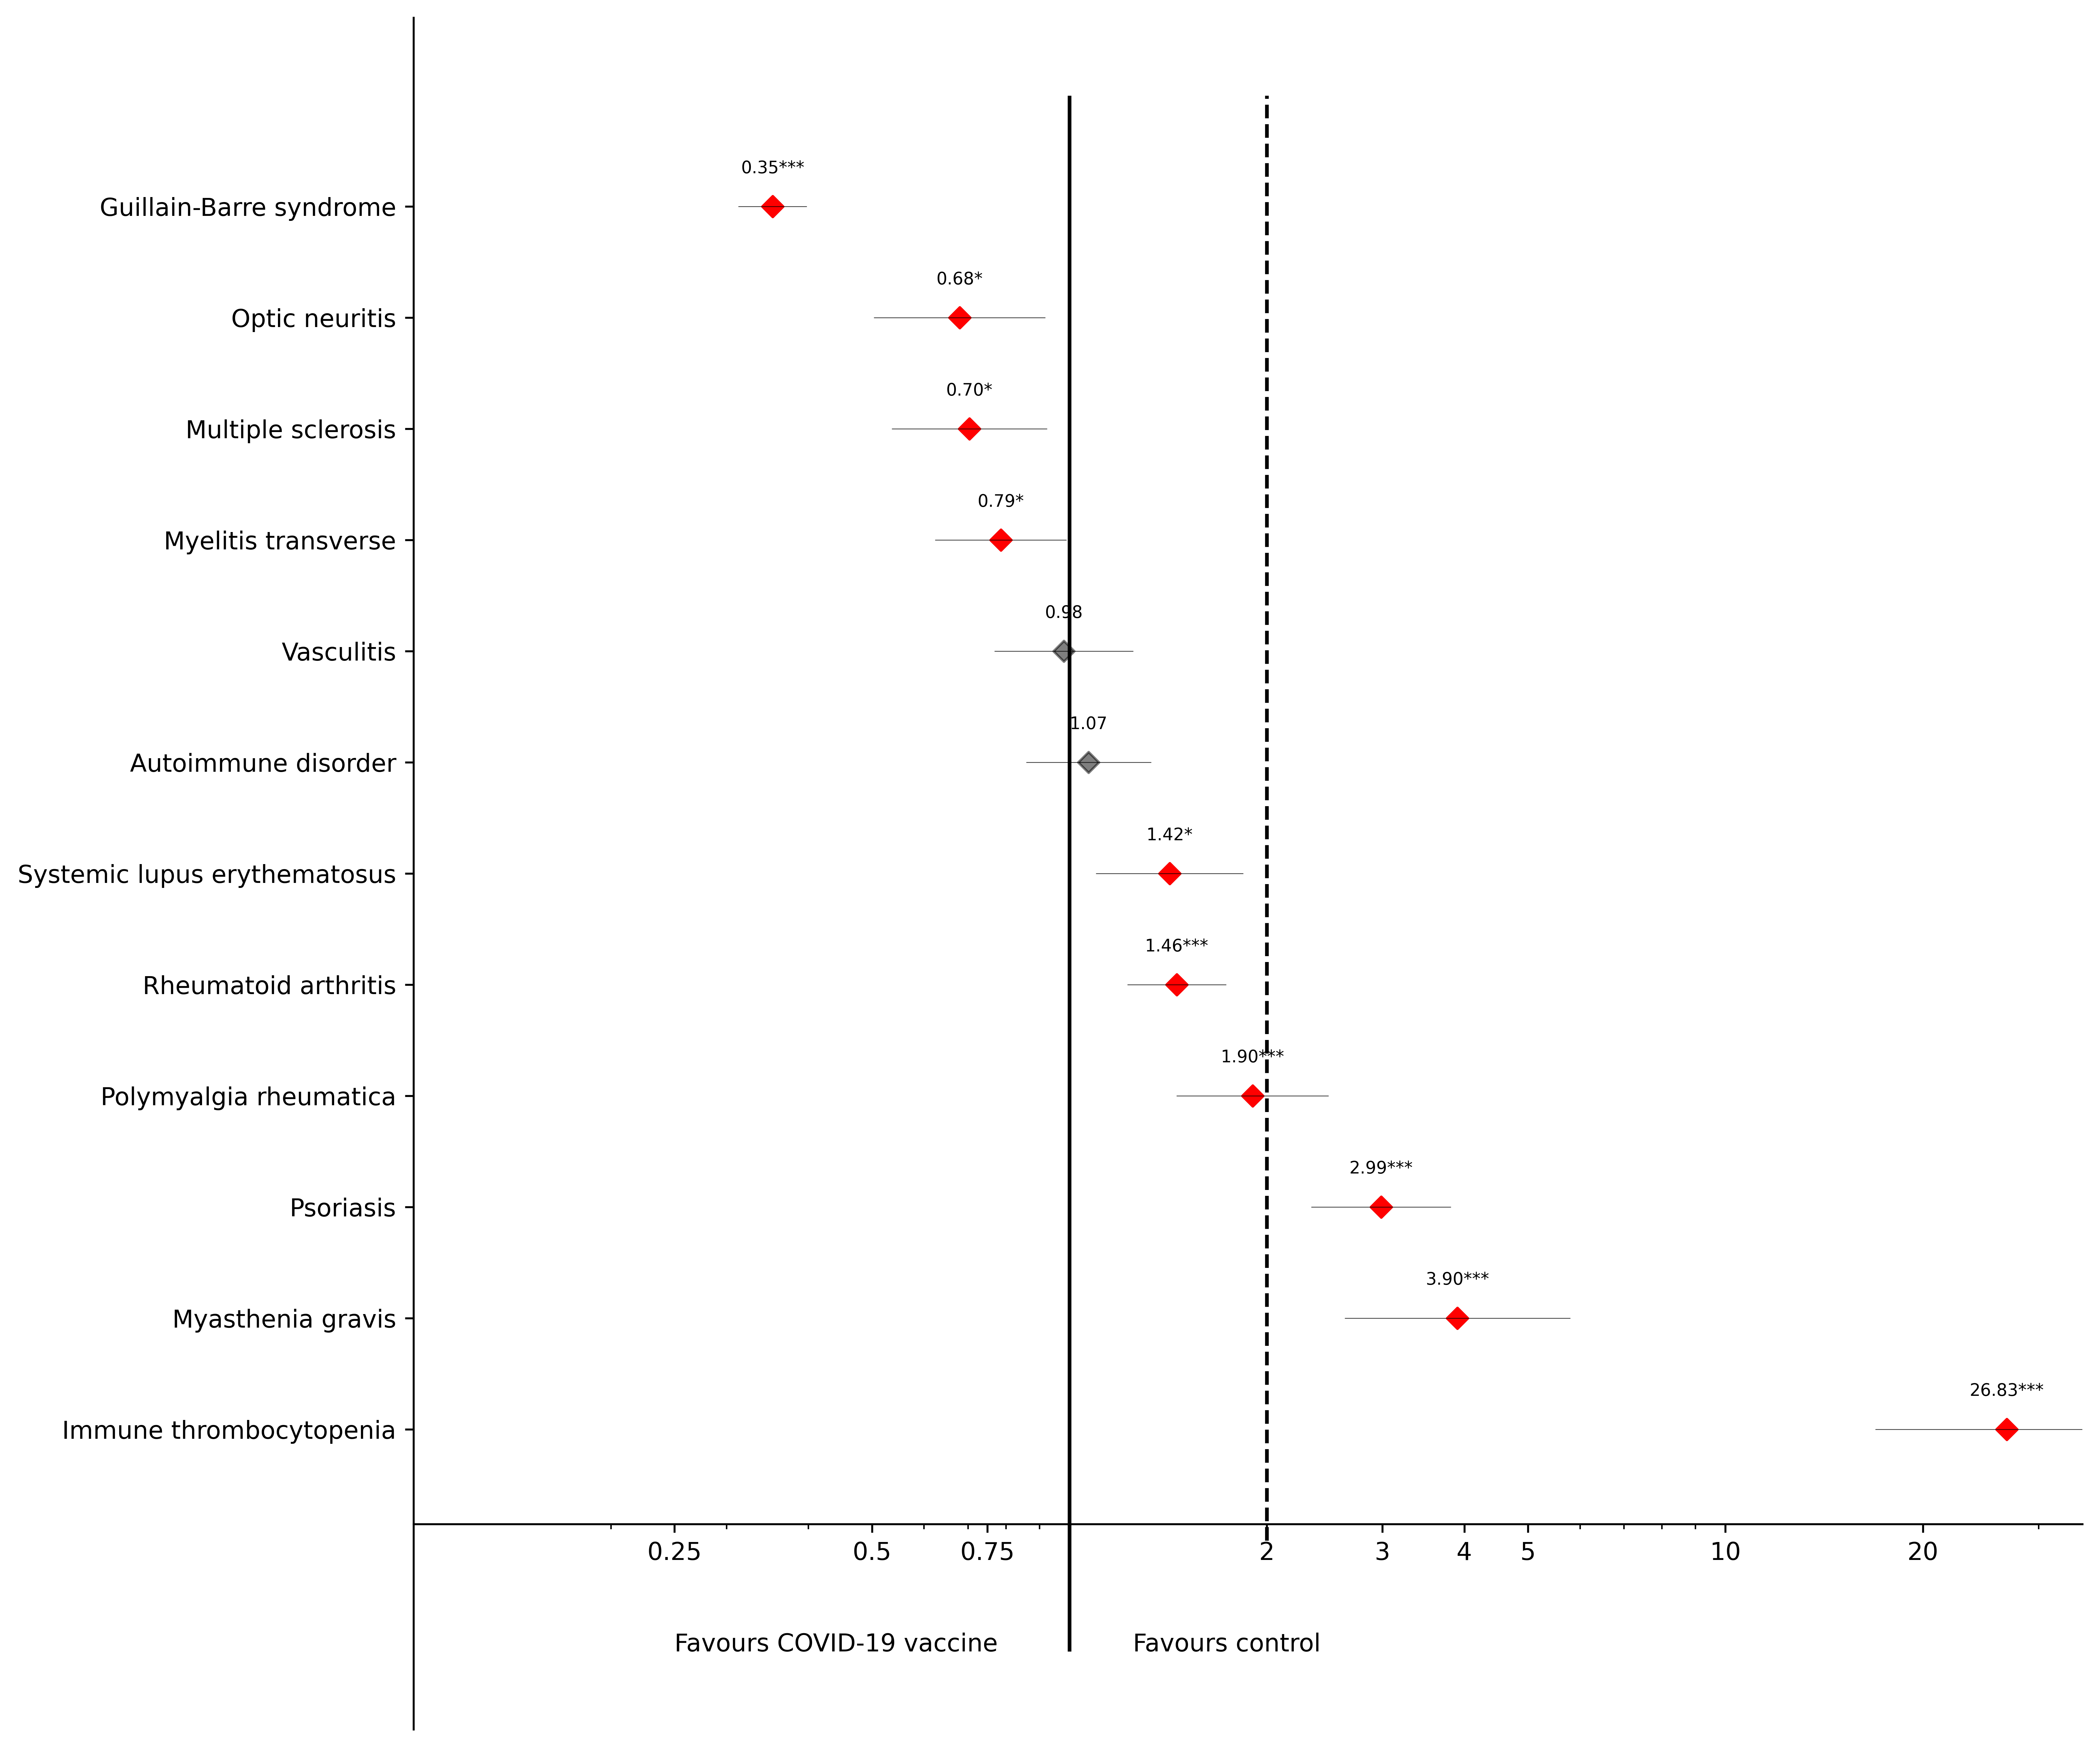

In [49]:
odds_ratios = odds_ratios[(odds_ratios["95CI_lower"] > 0.1) & (np.isfinite(odds_ratios.ROR) == True)]

try:
    odds_ratios.drop(["Butterfly rash", "Systemic lupus erythematosus rash"])
except KeyError:
    pass

fig, ax = plt.subplots(figsize=(12, 10), dpi=600)

ax.scatter(odds_ratios.ROR, odds_ratios.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios[odds_ratios.p_value < 0.05].ROR, odds_ratios[odds_ratios.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-2, ymax=len(odds_ratios.index), colors="k")
ax.vlines(x=2, ymin=-1, ymax=len(odds_ratios.index), colors="k", linestyles="--")

for idx, val in enumerate(odds_ratios.index):
    ax.hlines(y=idx, xmin=odds_ratios.loc[val, "95CI_lower"], xmax=odds_ratios.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios.loc[val, "ROR"], s = f"{odds_ratios.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")

ax.set_xscale("log")
ax.set_xlim(1e-1, 3.5e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.12))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.text(25e-2, -2.0, "Favours COVID-19 vaccine")
ax.text(1 + 25e-2, -2.0, "Favours control")

ax.set_xticks([0.25, 0.5, 0.75, 2, 3, 4, 5, 10, 20])
ax.set_xticklabels([0.25, 0.5, 0.75, 2, 3, 4, 5, 10, 20])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_by_etiology.pdf")

plt.show()

In [51]:
odds_ratios

,ROR,SE,95CI_upper,95CI_lower,a,b,c,d,p_value
SYMPTOM,,,,,,,,,
Immune thrombocytopenia,26.833660,0.235081,42.538745,16.926812,192.0,24860.0,20.0,69488.0,1.278231e-86
Myasthenia gravis,3.904421,0.202022,5.801251,2.627796,59.0,24993.0,42.0,69466.0,1.520701e-11
Psoriasis,2.986474,0.125051,3.815967,2.337291,133.0,24919.0,124.0,69384.0,7.927957e-18
Polymyalgia rheumatica,1.901651,0.136243,2.483725,1.455989,91.0,24961.0,133.0,69375.0,4.488594e-06
Rheumatoid arthritis,1.457622,0.088490,1.733682,1.225520,196.0,24856.0,374.0,69134.0,3.273826e-05
Systemic lupus erythematosus,1.421380,0.132027,1.841169,1.097303,87.0,24965.0,170.0,69338.0,8.751211e-03
Autoimmune disorder,1.069666,0.111963,1.332150,0.858901,111.0,24941.0,288.0,69220.0,5.697082e-01
Vasculitis,0.980495,0.124234,1.250823,0.768590,88.0,24964.0,249.0,69259.0,9.017327e-01
Myelitis transverse,0.785891,0.117711,0.989830,0.623971,93.0,24959.0,328.0,69180.0,4.055504e-02
